In [0]:
from IPython.display import Image,display_png

下記colab用　kaggle.jsonをアップして実行する

In [0]:
!git clone https://github.com/zhixuhao/unet.git
!mkdir /root/.kaggle
!mv kaggle.json /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download -c tgs-salt-identification-challenge
!unzip train.zip -d train
!unzip test.zip -d test
!mv unet/* .

## 【問題1】学習・推定

In [0]:
# 学習（お試し）
!python3 main.py

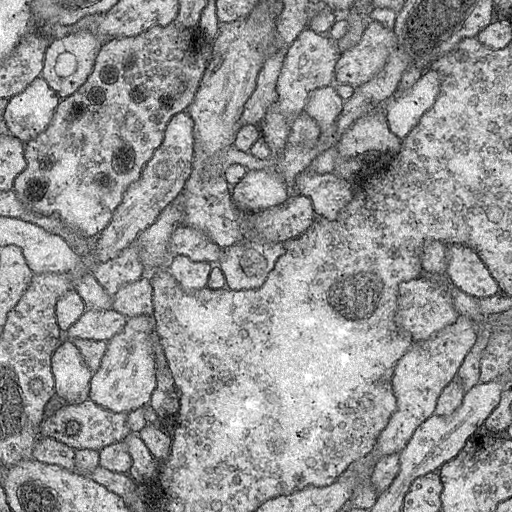

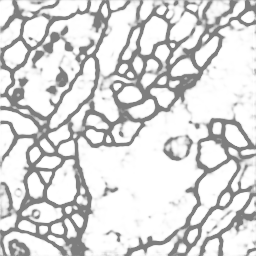

In [4]:
# 元データと推定結果（お試し）
display_png(Image('data/membrane/test/0.png'))
display_png(Image('data/membrane/test/0_predict.png'))

In [0]:
# test/images配下のファイル名を連番にする
!ls test/images/*.png | awk '{printf "mv  %s test/images/%s.png\n",$0,NR}' | sh
!mv test/images/18000.png test/images/0.png
!mkdir results
# コピーをとっとく
!cp main.py main1.py

In [12]:
%%writefile main.py
from model import *
from data import *

#os.environ["CUDA_VISIBLE_DEVICES"] = "0"


data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
myGene = trainGenerator(2,'train','images','masks',data_gen_args,image_color_mode='rgb')

model = unet(input_size=(256, 256, 3))
model_checkpoint = ModelCheckpoint('unet_membrane.hdf5', monitor='loss',verbose=1, save_best_only=True)
model.fit_generator(myGene,steps_per_epoch=300,epochs=1,callbacks=[model_checkpoint])

testGene = testGenerator("test/images",flag_multi_class=True,as_gray=False)
results = model.predict_generator(testGene,30,verbose=1)
saveResult("results",results)
model.summary()

Overwriting main.py


In [13]:
# 学習
!python3 main.py

Using TensorFlow backend.
W0617 20:28:37.340556 140373461469056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0617 20:28:37.350866 140373461469056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0617 20:28:37.352687 140373461469056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0617 20:28:37.375662 140373461469056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0617 20:28:37.442

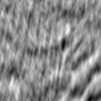

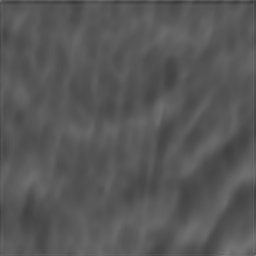

In [11]:
# 元データと推定結果
display_png(Image('test/images/1.png'))
display_png(Image('results/1_predict.png'))  # 真っ黒

## 【問題2】コードリーディング
使用したgithubのコードリーディングから。ざっくり書く。
https://github.com/zhixuhao/unet

## main.py  
インターフェース  
https://github.com/zhixuhao/unet/blob/master/main.py  
Imports：model.py, data.pyの関数を全てインポートしている  
In：学習用・マスク・検証用の画像ファイル  
Out：検証用画像から予測を行った画像ファイル  
Flow
1. data augmentationに必要な各パラメータを辞書型で作成し変数に格納する。
2. trainGenerator()をコールし、[keras.Model.fit_generator()](https://keras.io/ja/models/sequential/#fit_generator)に渡すためのオブジェクトを作成する。
3. [keras.callbacks.ModelCheckpoint() ](https://keras.io/ja/callbacks/#modelcheckpoint)をコールし、学習のlossを記録するためのオブジェクトを作成する。
4. [keras.Model.fit_generator()](https://keras.io/ja/models/sequential/#fit_generator)をコールし、学習を行う。引数に2. 3. のオブジェクトを渡す。
5. testGenerator()をコールし、[keras.Model.predict_generator()](https://keras.io/ja/models/sequential/#predict_generator)に渡すためのndarrayを作成する。
6. [keras.Model.predict_generator()](https://keras.io/ja/models/sequential/#predict_generator)をコールし、予測を行う。
7. data.saveResult()をコールし、予測結果を指定したディレクトリに画像として保存する。

## data.py
https://github.com/zhixuhao/unet/blob/master/data.py  
Imports：ImageDataGenerator, numpy, os, glob, skimage
### adjustData()
画像データ(ndarray)を後続の処理用にadjustする関数  
Arguments  
img(ndarray)：imageの画像データが格納されたndarray  
mask(ndarray)：maskの画像データが格納されたndarray  
flag_multi_class(bool)：maskするクラスが複数かどうか True→複数 False→2値分類　default：False  
num_class(int)：maskのクラス数   
<br>
Flow
1. (カラーの場合) maskのshapeをカラー用にadjustする
2. (ndarrayの最大値が1を超える場合) image・maskを画素数(255)で割る　maskはバイナリに変換
3. img, maskを返却する
<br>
<br>

### trainGenerator()
[keras.Model.fit_generator()](https://keras.io/ja/models/sequential/#fit_generator)用のオブジェクト作成関数  
Arguments  
batch_size(int)： [ImageDataGenerator()](https://keras.io/ja/preprocessing/image/)のバッチサイズ指定用 
train_path(str)：trainまでのパス  
image_folder(str)：imageが格納されているディレクトリ名  
mask_folder(str)：maskが格納されているディレクトリ名  
aug_dict(dict)：[ImageDataGenerator()](https://keras.io/ja/preprocessing/image/)の各種パラメータ  
image_color_mode(str)：[ImageDataGenerator()](https://keras.io/ja/preprocessing/image/)のカラー指定用 default：grayscale  
mask_color_mode(str)：[ImageDataGenerator()](https://keras.io/ja/preprocessing/image/)のカラー指定用  
image_save_prefix(str)：画像保存時のprefix default：image  
mask_save_prefix(str)：画像保存時のprefix  default：mask  
flag_multi_class(bool)：maskするクラスが複数かどうか True→複数 False→2値分類　default：False  
num_class(int)：maskのクラス数　default：2  
save_to_dir(str)：data augmentationの結果を保存するパス　default：None  
target_size(tuple)：ピクセル数　defalut：(256, 256)  
seed：[ImageDataGenerator()](https://keras.io/ja/preprocessing/image/)のシャッフルシード数　 default：1  
<br>
Flow
1. ImageDataGenerator()でimage・maskそれぞれのdata augmentationを行う。
2. 1.で作成したimage・maskそれぞれのオブジェクトを[zip()](https://note.nkmk.me/python-zip-usage-for/)でまとめる。
3. 2.でまとめたオブジェクトをfor文で処理する。
4. １データごとにadjustData()に渡し、[yield()](http://ailaby.com/yield/)で返却する
<br>
<br>

### testGenerator()
[keras.Model.predict_generator()](https://keras.io/ja/models/sequential/#predict_generator)用のndarray作成関数  
Arguments  
test_path(str)：検証用データが格納されているパス  
num_image(int)：検証用に使う画像の枚数　default：30  
target_size(tuple)：ピクセル数(256,256)  
flag_multi_class(bool)：maskするクラスが複数かどうか True→複数 False→2値分類　default：False  
as_gray(bool)：画像を白黒として使用するか　True→する False→しない　default：True  
<br>
Flow  
以下num_image数分ループ
1. 検証用データをndarrayとしてロードする。
2. 1.でロードしたデータを画素数(255)で割る。
3. target_sizeのピクセル数にリサイズ([skimage.transform.resize()](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize))
4. [keras.Model.predict_generator()](https://keras.io/ja/models/sequential/#predict_generator)の処理の形に合うようにreshapeする。
<br>
<br>

### saveResult()
予測結果を格納する関数  
Arguments  
save_path(str)：格納先のパス
npyfile(ndarray)：予測結果
flag_multi_class：maskするクラスが複数かどうか True→複数 False→2値分類　default：False 
num_class：maskのクラス数　default：2
<br>
Flow  
以下npyfile数分ループ
1. (flag_multi_classがTrueの場合)labelVisualize()をコール
2. (flag_multi_classがFalseの場合)[skimage.io.imsave](https://scikit-image.org/docs/dev/api/skimage.io.html#skimage.io.imsave)が処理できる形にreshape([:, :, 0])
3. [skimage.io.imsave](https://scikit-image.org/docs/dev/api/skimage.io.html#skimage.io.imsave)で画像データをセーブ
<br>
<br>

### labelVisualize()
ラベルをビジュアライズする関数(今回は複数クラスではないため割愛)  
<br>

### geneTrainNpy()
npyファイル生成用関数(使用しないため割愛)

## model.py
https://github.com/zhixuhao/unet/blob/master/model.py  
imports：numpy, os, skimage, keras.model.\*, keras.layers.\*, keras.optimizers.\*, keras.callbacks.\*, keras.backend

### unet()
unetのmodelオブジェクトを作成する関数(keras.Modelを継承して作成していないのは、継承機能ができる前に作成したから？)  
https://github.com/zhixuhao/unet/blob/master/model.py  
Arguments  
pretrained_weights(ndarray)：pretrainした重み(転移学習用？)  　default：None  
input_size(tuple)：インプットのサイズ　default：(256,256,1)  
<br>
モデル概要  
Lv.4の深さまでの畳み込み層で構成されている(下記画像参照)  
[Conv2D()](https://keras.io/ja/layers/convolutional/#conv2d)のオプション  
　activation：relu(output：sigmoid)  
　padding：same  (入力のサイズを維持する)  
　kernel_initializer：he_normal  
[MaxPooling2D()](https://keras.io/ja/layers/pooling/#maxpooling2d)のオプション  
　poolsize：(2, 2)  
[Dropout()](https://keras.io/ja/layers/core/#dropout)  
　rate：0.5  
各レベルの処理  
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 128, 128, 128 73856       max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 128, 128, 128 147584      conv2d_3[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 64, 64, 128)  0           conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 64, 64, 256)  295168      max_pooling2d_2[0][0]            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 64, 64, 256)  590080      conv2d_5[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 32, 32, 256)  0           conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 32, 32, 512)  1180160     max_pooling2d_3[0][0]            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 32, 32, 512)  2359808     conv2d_7[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 32, 32, 512)  0           conv2d_8[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 16, 16, 512)  0           dropout_1[0][0]                  
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 16, 16, 1024) 4719616     max_pooling2d_4[0][0]            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 16, 16, 1024) 9438208     conv2d_9[0][0]                   
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 16, 16, 1024) 0           conv2d_10[0][0]                  
__________________________________________________________________________________________________
up_sampling2d_1 (UpSampling2D)  (None, 32, 32, 1024) 0           dropout_2[0][0]                  
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 32, 32, 512)  2097664     up_sampling2d_1[0][0]            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 32, 32, 1024) 0           dropout_1[0][0]                  
                                                                 conv2d_11[0][0]                  
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 32, 32, 512)  4719104     concatenate_1[0][0]              
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 32, 32, 512)  2359808     conv2d_12[0][0]                  
__________________________________________________________________________________________________
up_sampling2d_2 (UpSampling2D)  (None, 64, 64, 512)  0           conv2d_13[0][0]                  
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 64, 64, 256)  524544      up_sampling2d_2[0][0]            
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 64, 64, 512)  0           conv2d_6[0][0]                   
                                                                 conv2d_14[0][0]                  
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 64, 64, 256)  1179904     concatenate_2[0][0]              
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 64, 64, 256)  590080      conv2d_15[0][0]                  
__________________________________________________________________________________________________
up_sampling2d_3 (UpSampling2D)  (None, 128, 128, 256 0           conv2d_16[0][0]                  
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 128, 128, 128 131200      up_sampling2d_3[0][0]            
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 128, 128, 256 0           conv2d_4[0][0]                   
                                                                 conv2d_17[0][0]                  
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 128, 128, 128 295040      concatenate_3[0][0]              
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 128, 128, 128 147584      conv2d_18[0][0]                  
__________________________________________________________________________________________________
up_sampling2d_4 (UpSampling2D)  (None, 256, 256, 128 0           conv2d_19[0][0]                  
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 256, 256, 64) 32832       up_sampling2d_4[0][0]            
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 256, 256, 128 0           conv2d_2[0][0]                   
                                                                 conv2d_20[0][0]                  
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 256, 256, 64) 73792       concatenate_4[0][0]              
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 256, 256, 64) 36928       conv2d_21[0][0]                  
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 256, 256, 2)  1154        conv2d_22[0][0]                  
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 256, 256, 1)  3           conv2d_23[0][0]                  
Total params: 31,032,837
Trainable params: 31,032,837
Non-trainable params: 0
__________________________________________________________________________________________________


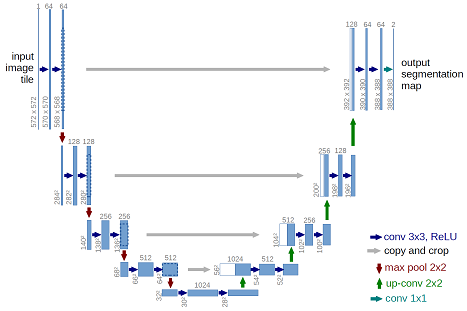

In [0]:
display_png(Image('u-net-architecture.png'))